In [1]:
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer 
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/last-dataset/last_dataset.csv")

In [3]:
df.head()

,Unnamed: 0,review,sentiment
0,0,bayiler satar artık e burası türkiye,positive
1,1,fiyatlara bin ekleyin bayide bulamayacaksınız ...,positive
2,2,motor kasaya yakışmış,positive
3,3,tl eksik aracı almam neyse sene bekleyem alırım,positive
4,4,eskiden milyoner olmak vardı derlerdi nerden g...,positive


In [4]:
X_train, X_test = train_test_split(df, test_size=0.25,random_state=42)

In [5]:
X_test

,Unnamed: 0,review,sentiment
36262,36262,yardımlarınız gerçekten teşekkür ederim halen ...,positive
36783,36783,kardeş ben yıldır dizel logan kullanıyorum zat...,positive
32633,32633,ben bir göz gezdirdim bin liraya çıkan modelle...,positive
14564,14564,tdi fiyat alan oldu arkadaşlar bin liste fiyat...,positive
50638,50638,hayırlı olsun,positive
...,...,...,...
14471,14471,model tdi coupe almayı düşünüyorum civarı km g...,negative
48558,48558,avrupa an satılıyor,positive
7831,7831,tsi polonun performansı gayet tatminkar kadar ...,positive
47091,47091,maalesef çalışmadı dizel bir modeline cc olmuy...,negative


In [6]:
X_train.shape

(48333, 3)

In [7]:
type(X_train)

pandas.core.frame.DataFrame

In [8]:
X_train["review"]

15962    quoteorijinalden alıntı ankara_ahmet teşekkür ...
6748     quoteorijinalden alıntı fc nin motorunun üstün...
25124    maaşallah arabanız güzelmiş bende aynı özellik...
6420     hayırlı olsun şimdiden hangi bayi lanet gelsin...
9724     uzaktan kumandalı araba galiba motor sesine eb...
                               ...                        
62570    kazanıp ye araççlardan b segment alırsın sadec...
38158    bunlara göre herşey hikaye pandemi çip savaş h...
860      scirocco nun kapısı gelmez mi arkadaşlar güzel...
15795    almanlar bizi kıskandığı fiyatları yüksek tutu...
56422                                             mercedes
Name: review, Length: 48333, dtype: object

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

In [10]:
def feature_extraction(df):
    tokenized = df['review'].apply((lambda x: tokenizer.encode(str(x), add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if (len(i) > max_len):
            max_len = len(i)
            
    last_hidden_states = []
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    all_hidden_states = []
    batch_size = 8
    for i in range(0, len(padded), batch_size):
        batch_input_ids = torch.tensor(padded[i:i+batch_size]).to(device)
        batch_attention_mask = torch.tensor(attention_mask[i:i+batch_size]).to(device)

        with torch.no_grad():
#             last_hidden_states += list(bert_model(batch_input_ids, attention_mask=batch_attention_mask)[0][0][0].cpu().numpy())
            last_hidden_states += list(bert_model(batch_input_ids, attention_mask=batch_attention_mask)[0][:,0,:].cpu().numpy())
#             list(x[0][0].cpu().numpy())
        
#         all_hidden_states.extend(last_hidden_states)
        
#     last_hidden_states[0].size()
#     torch.Size([668, 75, 768])
#     return last_hidden_states[0][:,0,:].numpy()
    return last_hidden_states
    

In [11]:
X_train_tokens = feature_extraction(X_train)

In [12]:
X_test_tokens = feature_extraction(X_test)

In [13]:
type(X_train_tokens)

list

In [14]:
def process_data(df,tokens):
    mapping = {'negative':0, 'neutral':1, 'positive':2}
    X = []
    y = []
    for idx, review in enumerate(tqdm(df["review"].values)):
        X.append(tokens[idx])
        y_val = np.zeros(3)
        y_val[mapping[df.iloc[idx]['sentiment']]] = 1
        y.append(y_val)
    return np.array(X), np.array(y)

In [15]:
X_train, y_train = process_data(X_train,X_train_tokens)

100%|██████████| 48333/48333 [00:02<00:00, 19570.64it/s]


In [16]:
X_test, y_test = process_data(X_test, X_test_tokens)

100%|██████████| 16112/16112 [00:00<00:00, 18975.09it/s]


# Training a Model with Keras

In [33]:
import keras 
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [18]:
# create model 
model = Sequential()
num_tokens = len(X_train_tokens[0])
model.add(Dense(128, input_shape=(num_tokens,), activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [19]:
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [28]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [31]:
history =model.fit(X_train, 
                y_train,
                validation_data=(X_test, y_test),
                batch_size=64, 
                shuffle=True,
                verbose=1,
                epochs=500,
                callbacks=[es, mc])

Epoch 1/500
750/756 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.9091
Epoch 1: val_accuracy did not improve from 0.91149
756/756 [==============================] - 4s 5ms/step - loss: 0.3144 - accuracy: 0.9090 - val_loss: 0.2993 - val_accuracy: 0.9115
Epoch 2/500
753/756 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.9093
Epoch 2: val_accuracy did not improve from 0.91149
756/756 [==============================] - 4s 5ms/step - loss: 0.3097 - accuracy: 0.9094 - val_loss: 0.2981 - val_accuracy: 0.9115
Epoch 3/500
756/756 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.9095
Epoch 3: val_accuracy did not improve from 0.91149
756/756 [==============================] - 4s 6ms/step - loss: 0.3076 - accuracy: 0.9095 - val_loss: 0.2988 - val_accuracy: 0.9115
Epoch 4/500
753/756 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.9095
Epoch 4: val_accuracy did not improve from 0.91149
756/756 [======

In [24]:
! pip install h5py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
saved_model = load_model('best_model.h5')

In [35]:
saved_model

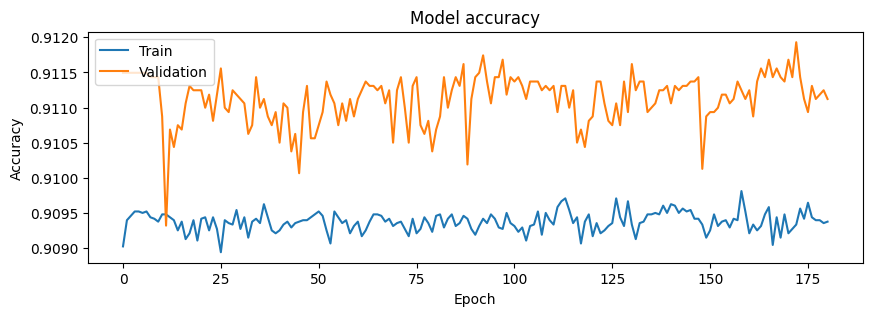

In [42]:
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

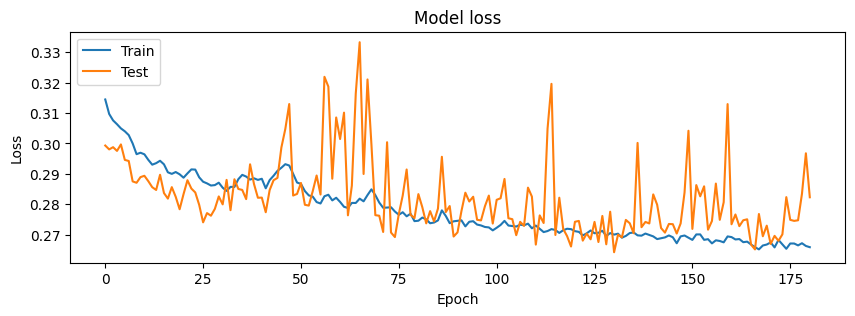

In [44]:
plt.figure(figsize=(10,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()